# Problem 1

In [129]:
# install all required packages
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [130]:
# Load data
file_path = "/Users/liruiqi/Desktop/project1/problem1.csv"
data = pd.read_csv(file_path)


In [142]:
# Part A
# Compute statistical moments
mean_val = np.mean(data.values.flatten())
variance_val = np.var(data.values.flatten(), ddof=1)
skewness_val = stats.skew(data.values.flatten())
kurtosis_val = stats.kurtosis(data.values.flatten(), fisher=True)

# Print results
print(f"Mean: {mean_val}")
print(f"Variance: {variance_val}")
print(f"Skewness: {skewness_val}")
print(f"Kurtosis: {kurtosis_val}")

Mean: 0.05019795790476916
Variance: 0.010332476407479588
Skewness: 0.1204447119194402
Kurtosis: 0.2229270674503816


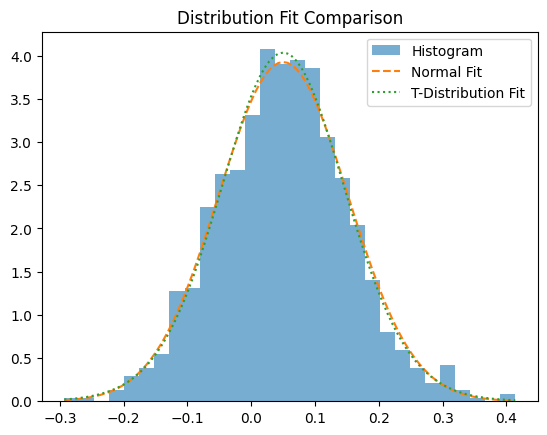

In [143]:
# Part B
# Compare Normal vs T-distribution
x = np.linspace(min(data.values)[0], max(data.values)[0], 100)

# Fit Normal Distribution
mu, sigma = stats.norm.fit(data.values.flatten())
normal_pdf = stats.norm.pdf(x, mu, sigma)

# Fit T-Distribution
df, loc, scale = stats.t.fit(data.values.flatten())
t_pdf = stats.t.pdf(x, df, loc, scale)

# Plot distributions
plt.hist(data.values.flatten(), bins=30, density=True, alpha=0.6, label="Histogram")
plt.plot(x, normal_pdf, label="Normal Fit", linestyle="dashed")
plt.plot(x, t_pdf, label="T-Distribution Fit", linestyle="dotted")
plt.legend()
plt.title("Distribution Fit Comparison")
plt.show()

In [140]:
# Goodness-of-fit test with improved readability
ks_normal_stat, ks_normal_pvalue = stats.kstest(data.values.flatten(), 'norm', args=(mu, sigma))
ks_t_stat, ks_t_pvalue = stats.kstest(data.values.flatten(), 't', args=(df, loc, scale))

print("Goodness-of-Fit Test Results:")
print(f"Normal Distribution: KS Statistic = {ks_normal_stat:.4f}, p-value = {ks_normal_pvalue:.4f}")
print(f"T-Distribution: KS Statistic = {ks_t_stat:.4f}, p-value = {ks_t_pvalue:.4f}")

Goodness-of-Fit Test Results:
Normal Distribution: KS Statistic = 0.0128, p-value = 0.9962
T-Distribution: KS Statistic = 0.0127, p-value = 0.9965


In [145]:
# Part C
# define the log_likelihood
normal_log_likelihood = np.sum(stats.norm.logpdf(data.values.flatten(), mu, sigma))
t_log_likelihood = np.sum(stats.t.logpdf(data.values.flatten(), df, loc, scale))

# Number of observations
n = len(data.values.flatten())

# Number of parameters: 2 for Normal, 3 for T-Distribution
aic_normal = 2 * 2 - 2 * normal_log_likelihood
bic_normal = 2 * np.log(n) - 2 * normal_log_likelihood

aic_t = 2 * 3 - 2 * t_log_likelihood
bic_t = 3 * np.log(n) - 2 * t_log_likelihood


# Print AIC and BIC values
print("\nModel Comparison using AIC and BIC:")
print(f"Normal Distribution: AIC = {aic_normal:.2f}, BIC = {bic_normal:.2f}")
print(f"T-Distribution: AIC = {aic_t:.2f}, BIC = {bic_t:.2f}")

# Choosing the best model based on AIC and BIC
if aic_normal < aic_t and bic_normal < bic_t:
    print("Normal Distribution is the better fit based on AIC and BIC.")
else:
    print("T-Distribution is the better fit based on AIC and BIC.")


Model Comparison using AIC and BIC:
Normal Distribution: AIC = -1731.59, BIC = -1721.77
T-Distribution: AIC = -1731.42, BIC = -1716.70
Normal Distribution is the better fit based on AIC and BIC.


# problem 2

In [204]:
# Load data
file_path = "/Users/liruiqi/Desktop/project1/problem2.csv"
data = pd.read_csv(file_path)

# Handle missing or invalid data
#data_cleaned = data.dropna()
#data_values = data_cleaned.values

In [205]:
# print(data_values)

In [206]:
# Part A
# Calculate the pairwise covariance matrix
cov_matrix = data.cov()
print("Pairwise Covariance Matrix:")
print(cov_matrix)

Pairwise Covariance Matrix:
          x1        x2        x3        x4        x5
x1  1.470484  1.454214  0.877269  1.903226  1.444361
x2  1.454214  1.252078  0.539548  1.621918  1.237877
x3  0.877269  0.539548  1.272425  1.171959  1.091912
x4  1.903226  1.621918  1.171959  1.814469  1.589729
x5  1.444361  1.237877  1.091912  1.589729  1.396186


In [207]:
# Part B
# Check if the matrix is at least positive semi-definite
def is_positive_semi_definite(matrix):
    """Check if a matrix is positive semi-definite."""
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues >= 0)

is_psd = is_positive_semi_definite(cov_matrix)
print(f"Is the covariance matrix positive semi-definite? {is_psd}")

Is the covariance matrix positive semi-definite? False


In [208]:
# Part C
# If the matrix is not positive semi-definite, find the nearest PSD matrix using Higham's method and Rebonato-Jackel method.

def nearest_positive_semi_definite_higham(matrix):
    """Find the nearest positive semi-definite matrix using Higham's method."""
    sym_matrix = (matrix + matrix.T) / 2
    eigvals, eigvecs = np.linalg.eigh(sym_matrix)
    eigvals[eigvals < 0] = 0  # Set negative eigenvalues to zero
    return eigvecs @ np.diag(eigvals) @ eigvecs.T

def nearest_positive_semi_definite_rebonato_jackel(matrix, epsilon=1e-8):
    """Find the nearest positive semi-definite matrix using Rebonato-Jackel method."""
    # Step 1: Eigenvalue decomposition
    eigenvalues, eigenvectors = np.linalg.eigh(matrix)
    
    # Step 2: Replace negative eigenvalues with a small non-negative value
    eigenvalues[eigenvalues < 0] = epsilon
    
    # Step 3: Reconstruct the covariance matrix
    adjusted_matrix = eigenvectors @ np.diag(eigenvalues) @ eigenvectors.T
    
    # Step 4: Rescale the matrix to match the original variances
    original_variances = np.diag(matrix)
    scaling_factors = np.sqrt(original_variances / np.diag(adjusted_matrix))
    scaling_matrix = np.diag(scaling_factors)
    
    final_matrix = scaling_matrix @ adjusted_matrix @ scaling_matrix
    return final_matrix

# Check if the covariance matrix is already positive semi-definite
if not is_psd:
    # Apply Higham's method
    nearest_psd_matrix_higham = nearest_positive_semi_definite_higham(cov_matrix)
    print("Nearest PSD Matrix (Higham):")
    print(nearest_psd_matrix_higham)
    
    # Apply Rebonato-Jackel method
    nearest_psd_matrix_rebonato = nearest_positive_semi_definite_rebonato_jackel(cov_matrix)
    print("\nNearest PSD Matrix (Rebonato-Jackel):")
    print(nearest_psd_matrix_rebonato)
else:
    print("The covariance matrix is already positive semi-definite.")


Nearest PSD Matrix (Higham):
[[1.61513295 1.44196041 0.89714421 1.78042572 1.43379434]
 [1.44196041 1.34696791 0.58508635 1.55455193 1.21140918]
 [0.89714421 0.58508635 1.29891578 1.11595578 1.07669234]
 [1.78042572 1.55455193 1.11595578 1.98316488 1.62137332]
 [1.43379434 1.21140918 1.07669234 1.62137332 1.40493616]]

Nearest PSD Matrix (Rebonato-Jackel):
[[1.47048437 1.32652813 0.84725458 1.62496988 1.36381777]
 [1.32652813 1.25207795 0.55831928 1.43363198 1.16431726]
 [0.84725458 0.55831928 1.272425   1.05649629 1.06233291]
 [1.62496988 1.43363198 1.05649629 1.81446921 1.54604392]
 [1.36381777 1.16431726 1.06233291 1.54604392 1.39618646]]


In [221]:
# D. Calculate covariance matrix using only overlapping data
def covariance_overlapping(data):
    overlapping_data = data.dropna()  # Drop rows with missing values
    return overlapping_data.cov()

cov_matrix_overlapping = covariance_overlapping(data)
print("Covariance Matrix Using Overlapping Data:")
print(cov_matrix_overlapping)

Covariance Matrix Using Overlapping Data:
          x1        x2        x3        x4        x5
x1  0.418604  0.394054  0.424457  0.416382  0.434287
x2  0.394054  0.396786  0.409343  0.398401  0.422631
x3  0.424457  0.409343  0.441360  0.428441  0.448957
x4  0.416382  0.398401  0.428441  0.437274  0.440167
x5  0.434287  0.422631  0.448957  0.440167  0.466272


# Problem 3

In [266]:
import pandas as pd
import numpy as np
from scipy.stats import multivariate_normal
from numpy.linalg import inv, cholesky
import statsmodels.api as sm

In [261]:
# Load data
file_path = "/Users/liruiqi/Desktop/project1/problem3.csv"
data = pd.read_csv(file_path)

In [267]:
# Part A
# Fit a multivariate normal to the data
# Calculate the mean vector and covariance matrix
mean_vector = data.mean().to_numpy()  # Convert to NumPy array
cov_matrix = data.cov().to_numpy()  # Convert to NumPy array

print("Mean vector:", mean_vector)
print("Covariance matrix:\n", cov_matrix)

Mean vector: [0.04600157 0.09991502]
Covariance matrix:
 [[0.0101622  0.00492354]
 [0.00492354 0.02028441]]


In [268]:
# Part B
# Distribution of X2 given X1=0.6 using two methods

# Method 1: Conditional distribution formula
x1_value = 0.6

mu_x1, mu_x2 = mean_vector[0], mean_vector[1]
sigma_x1x1, sigma_x2x2 = cov_matrix[0, 0], cov_matrix[1, 1]
sigma_x1x2 = cov_matrix[0, 1]

# Compute conditional mean and variance
conditional_mean = mu_x2 + (sigma_x1x2 / sigma_x1x1) * (x1_value - mu_x1)
conditional_variance = sigma_x2x2 - (sigma_x1x2 ** 2) / sigma_x1x1

print("Conditional mean of X2 given X1=0.6:", conditional_mean)
print("Conditional variance of X2 given X1=0.6:", conditional_variance)

# Method 2: Using the OLS Method

# Perform OLS regression (X2 ~ X1)
X = sm.add_constant(data['x1'])  # Add constant term for the intercept
y = data['x2']
ols_model = sm.OLS(y, X).fit()

# Get the fitted values and the regression parameters
intercept, slope = ols_model.params
predicted_X2_given_X1 = intercept + slope * x1_value

# Print the conditional mean and the variance from OLS
print(f'Conditional mean of X2 given X1={x1_value} using OLS: {predicted_X2_given_X1}')

# Estimate variance using residuals from OLS
residuals = ols_model.resid
estimated_variance = np.var(residuals, ddof=1)  # Using ddof=1 for sample variance

print(f'Estimated variance of X2 given X1 using OLS: {estimated_variance}')
print(f'Slope (beta_1): {slope}, Intercept: {intercept}')

Conditional mean of X2 given X1=0.6: 0.3683249958609775
Conditional variance of X2 given X1=0.6: 0.017898969645087522
Conditional mean of X2 given X1=0.6 using OLS: 0.36832499586097767
Estimated variance of X2 given X1 using OLS: 0.017898969645087526
Slope (beta_1): 0.48449591027977523, Intercept: 0.07762744969311253


In [270]:
#Partc
from scipy.linalg import cholesky

# Define mean vector and covariance matrix (example values)
mean_vector = np.array([0, 0])  # Replace with actual mean vector
cov_matrix = np.array([[1, 0.5], [0.5, 1]])  # Replace with actual covariance matrix

# Parameters for simulation
num_samples = 10000000  # Number of simulations (large enough to ensure sufficient samples)
tolerance = 0.05  # Acceptable range around the target value
x1_value = 0.6  # Target value for X1

# Cholesky decomposition of covariance matrix
L = cholesky(cov_matrix)

# Generate multivariate normal samples
standard_normal_samples = np.random.randn(num_samples, 2)  # Standard normal variables
multivariate_samples = mean_vector + standard_normal_samples @ L.T  # Transform to target distribution

# Filter samples where X1 is close to the target value
filtered_samples = multivariate_samples[np.abs(multivariate_samples[:, 0] - x1_value) < tolerance]

# Check if any samples are found
if len(filtered_samples) == 0:
    print(f"No samples found for X1 close to {x1_value} within tolerance {tolerance}. "
          f"Consider increasing sample size or tolerance.")
else:
    # Compute empirical mean and variance of X2 | X1=0.6
    empirical_mean_x2_given_x1 = np.mean(filtered_samples[:, 1])
    empirical_var_x2_given_x1 = np.var(filtered_samples[:, 1], ddof=1)

    # Print simulation results
    print("\nSimulation Results:")
    print(f"Empirical Mean of X2 | X1={x1_value}: {empirical_mean_x2_given_x1}")
    print(f"Empirical Variance of X2 | X1={x1_value}: {empirical_var_x2_given_x1}")



Simulation Results:
Empirical Mean of X2 | X1=0.6: 0.2091168842544608
Empirical Variance of X2 | X1=0.6: 0.5980409312602568


# Problem 4

In [161]:
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [162]:
# Load dataset
file_path = "/Users/liruiqi/Desktop/project1/problem4.csv"
data = pd.read_csv(file_path)

# Extract time series
ts = data.iloc[:, 0]

In [163]:
# Part A
# --- Part (A) Simulate MA(1), MA(2), MA(3) Processes ---

def simulate_MA(q, theta_values, n=500):
    """Simulate MA(q) process with given θ parameters."""
    np.random.seed(42)
    epsilon = np.random.normal(size=n)
    ma_process = np.zeros(n)

    for t in range(q, n):
        ma_process[t] = epsilon[t] + sum(theta_values[i] * epsilon[t - (i + 1)] for i in range(q))
    
    return ma_process

In [57]:
# Define θ values for MA(1), MA(2), MA(3)
theta1 = [0.5]  # MA(1)
theta2 = [0.5, -0.3]  # MA(2)
theta3 = [0.5, -0.3, 0.2]  # MA(3)

# Generate MA processes
ma1 = simulate_MA(1, theta1)
ma2 = simulate_MA(2, theta2)
ma3 = simulate_MA(3, theta3)

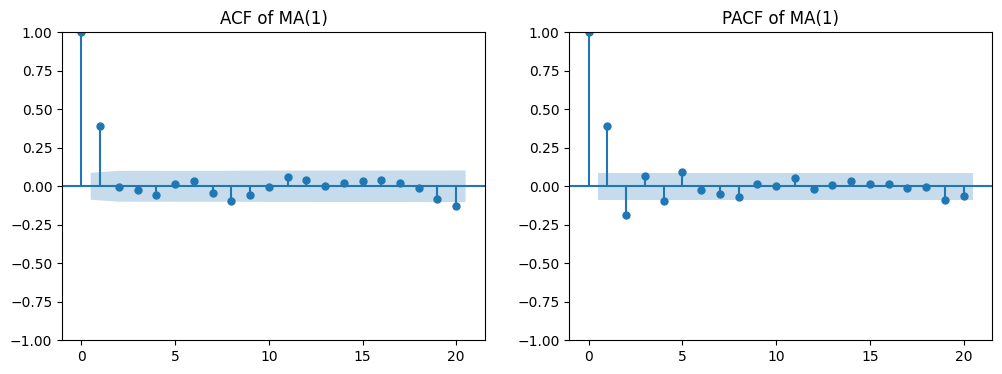

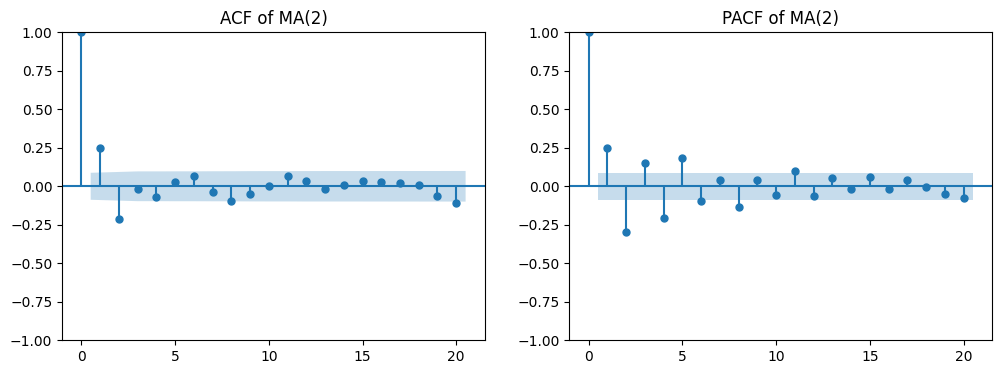

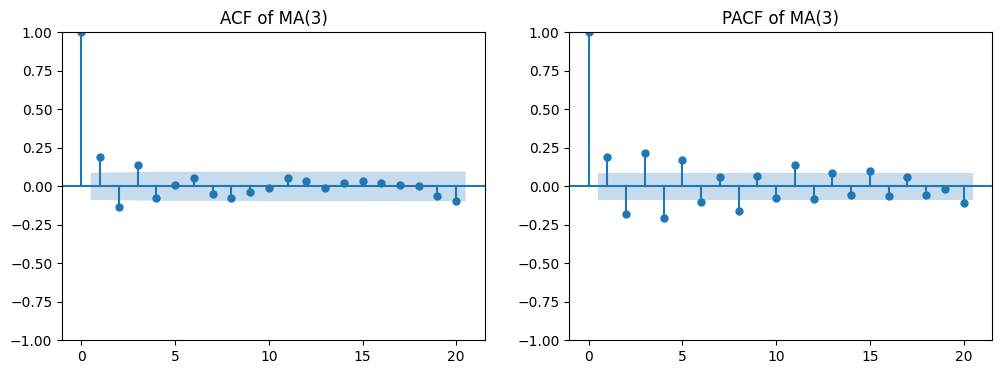

In [58]:
# Function to plot ACF and PACF
def plot_acf_pacf(series, title):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sm.graphics.tsa.plot_acf(series, lags=20, ax=axes[0])
    sm.graphics.tsa.plot_pacf(series, lags=20, ax=axes[1])
    axes[0].set_title(f"ACF of {title}")
    axes[1].set_title(f"PACF of {title}")
    plt.show()
    
# Plot ACF/PACF for MA processes
plot_acf_pacf(ma1, "MA(1)")
plot_acf_pacf(ma2, "MA(2)")
plot_acf_pacf(ma3, "MA(3)")

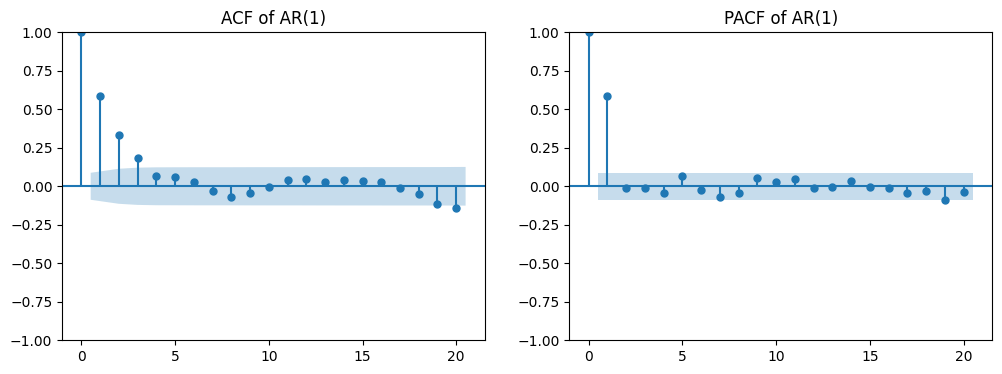

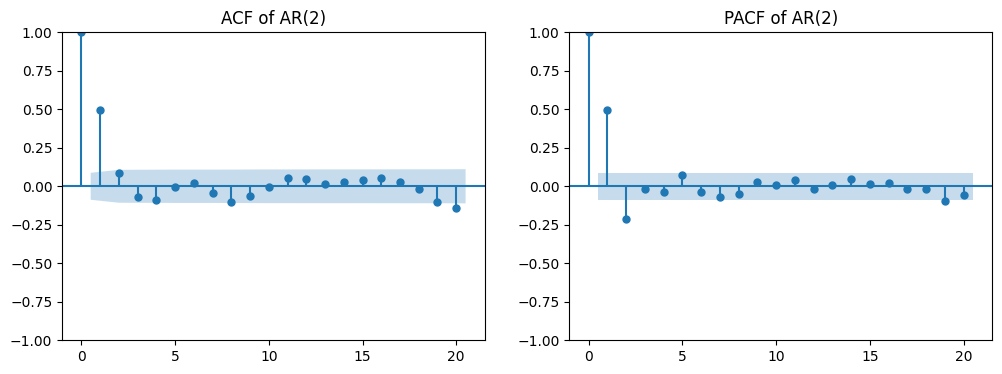

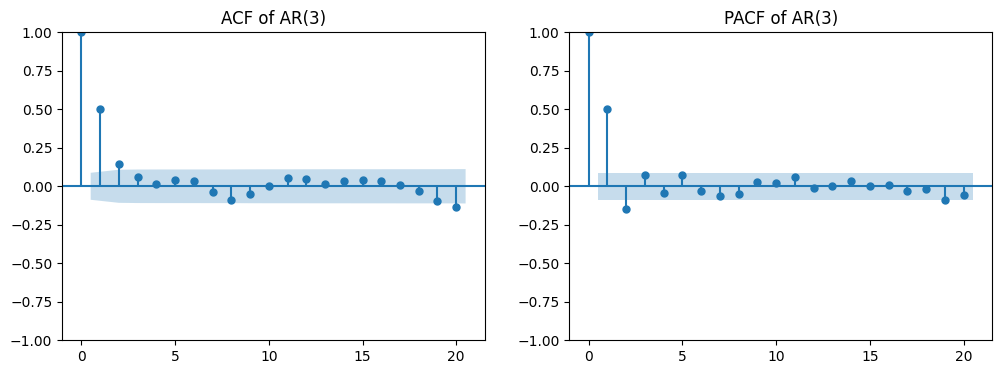

In [164]:
# Part B
# --- Part (B) Simulate AR(1), AR(2), AR(3) Processes ---

def simulate_AR(p, phi_values, n=500):
    """Simulate AR(p) process with given φ parameters."""
    np.random.seed(42)
    epsilon = np.random.normal(size=n)
    ar_process = np.zeros(n)

    for t in range(p, n):
        ar_process[t] = sum(phi_values[i] * ar_process[t - (i + 1)] for i in range(p)) + epsilon[t]

    return ar_process

# Define φ values for AR(1), AR(2), AR(3)
phi1 = [0.6]  # AR(1)
phi2 = [0.6, -0.2]  # AR(2)
phi3 = [0.6, -0.2, 0.1]  # AR(3)

# Generate AR processes
ar1 = simulate_AR(1, phi1)
ar2 = simulate_AR(2, phi2)
ar3 = simulate_AR(3, phi3)

# Plot ACF/PACF for AR processes
plot_acf_pacf(ar1, "AR(1)")
plot_acf_pacf(ar2, "AR(2)")
plot_acf_pacf(ar3, "AR(3)")

Plotting the actual time series data:


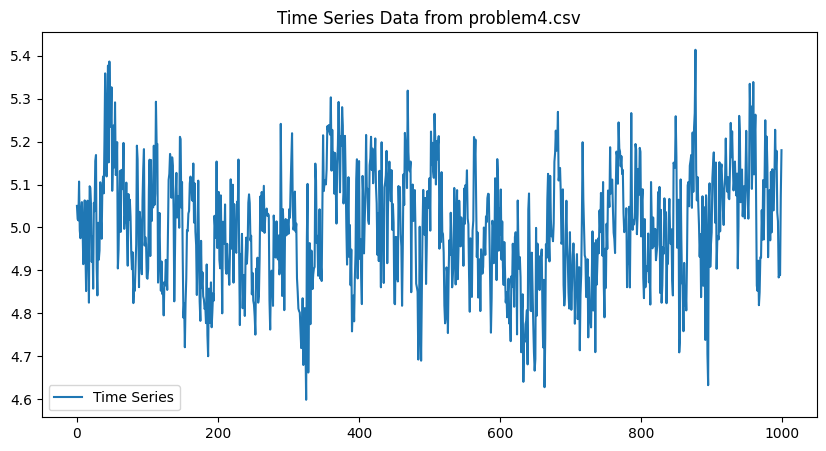

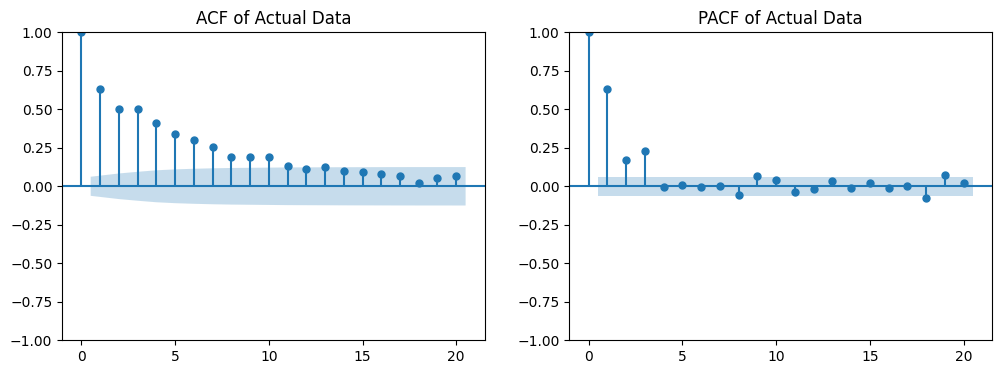

In [165]:
# Part C
# --- Part (C) Examine the Data and Identify Best Model ---

print("Plotting the actual time series data:")
plt.figure(figsize=(10, 5))
plt.plot(ts, label="Time Series")
plt.legend()
plt.title("Time Series Data from problem4.csv")
plt.show()

# Plot ACF and PACF for the actual data
plot_acf_pacf(ts, "Actual Data")

In [222]:
# Part D
# --- Part (D) Fit AR/MA Models and Compare AICc ---

# Test different ARMA models and compare AICc
best_model = None
best_aicc = np.inf
best_order = None

for p in range(4):  # Test AR terms from 0 to 3
    for q in range(4):  # Test MA terms from 0 to 3
        if p == 0 and q == 0:
            continue  # Skip ARMA(0,0)
        try:
            model = ARIMA(ts, order=(p, 0, q))
            result = model.fit()
            aicc = result.aic + (2 * (p + q + 1) * (p + q + 2)) / (len(ts) - p - q - 2)  # AICc formula
            print(f"ARMA({p},{q}) - AICc: {aicc:.2f}")

            # Update best model
            if aicc < best_aicc:
                best_aicc = aicc
                best_model = result
                best_order = (p, q)
        except:
            continue  # Skip models that fail to converge

print(f"\nBest model: ARMA{best_order} with AICc: {best_aicc:.2f}")


ARMA(0,1) - AICc: -1508.91
ARMA(0,2) - AICc: -1559.23
ARMA(0,3) - AICc: -1645.09
ARMA(1,0) - AICc: -1669.08
ARMA(1,1) - AICc: -1723.43
ARMA(1,2) - AICc: -1728.85
ARMA(1,3) - AICc: -1744.08
ARMA(2,0) - AICc: -1696.07


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARMA(2,1) - AICc: -1725.43
ARMA(2,2) - AICc: -1739.99
ARMA(2,3) - AICc: -1742.50
ARMA(3,0) - AICc: -1746.24
ARMA(3,1) - AICc: -1744.25
ARMA(3,2) - AICc: -1742.29
ARMA(3,3) - AICc: -1740.41

Best model: ARMA(3, 0) with AICc: -1746.24


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Problem 5

In [189]:
pip install scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [190]:
from sklearn.decomposition import PCA

In [191]:
# Load stock return data
file_path = "/Users/liruiqi/Desktop/project1/DailyReturn.csv"  # Adjust as needed
returns = pd.read_csv(file_path, index_col=0)

In [224]:
# --- Part A: Exponentially Weighted Covariance Matrix ---

def exp_weighted_cov_matrix(data, lambd):
    """
    Calculate exponentially weighted covariance matrix.
    :param data: DataFrame of stock returns.
    :param lambd: Decay factor (0 < lambd < 1).
    :return: Exponentially weighted covariance matrix.
    """
    n, T = data.shape[1], data.shape[0]
    weights = np.array([lambd**(T-t-1) for t in range(T)])
    weights /= weights.sum()  # Normalize weights
    mean_vec = np.average(data, axis=0, weights=weights)
    centered_data = data - mean_vec
    weighted_cov = np.dot((centered_data * weights[:, None]).T, centered_data)
    return weighted_cov

# Example: Calculate for λ = 0.97
lambda_val = 0.97
ew_cov_matrix = exp_weighted_cov_matrix(returns.values, lambda_val)
print("Exponentially Weighted Covariance Matrix (λ=0.97):")
print(ew_cov_matrix)

Exponentially Weighted Covariance Matrix (λ=0.97):
[[7.19328492e-05 5.39025561e-05 1.24211898e-04 ... 5.90676803e-05
  1.26977172e-04 5.26657656e-05]
 [5.39025561e-05 1.39267406e-04 4.08463903e-05 ... 5.99870926e-05
  8.39458050e-05 3.78230986e-05]
 [1.24211898e-04 4.08463903e-05 6.62806598e-04 ... 1.41563912e-05
  3.21709386e-04 4.95822627e-05]
 ...
 [5.90676803e-05 5.99870926e-05 1.41563912e-05 ... 2.50136306e-04
  8.43975411e-05 8.80937769e-05]
 [1.26977172e-04 8.39458050e-05 3.21709386e-04 ... 8.43975411e-05
  7.38435342e-04 7.33886829e-05]
 [5.26657656e-05 3.78230986e-05 4.95822627e-05 ... 8.80937769e-05
  7.33886829e-05 1.53172671e-04]]


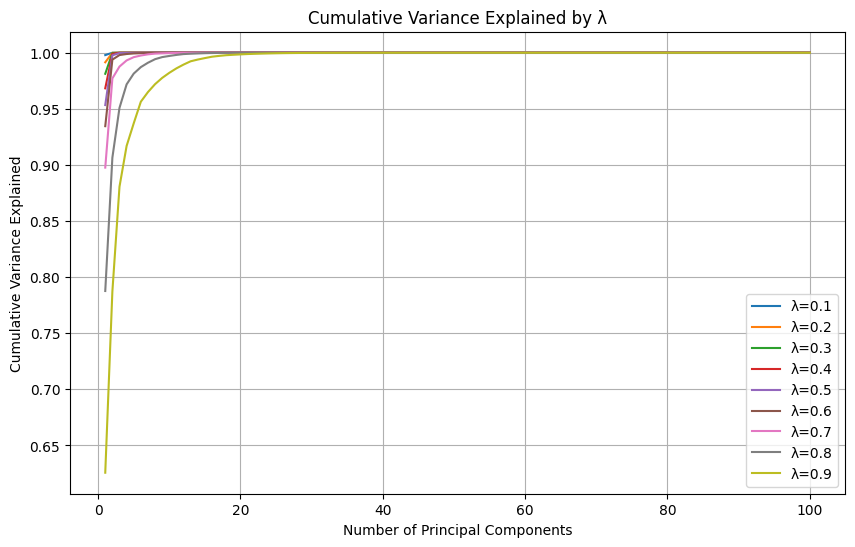

In [214]:
# --- Part B: Vary λ and Perform PCA ---

lambda_values = np.linspace(0.1, 0.9, 9)  # λ values in (0,1)
explained_variance = {}

for lambd in lambda_values:
    cov_matrix = exp_weighted_cov_matrix(returns.values, lambd)
    pca = PCA()
    pca.fit(cov_matrix)
    cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
    explained_variance[lambd] = cumulative_variance

# Plot cumulative variance explained for each λ
plt.figure(figsize=(10, 6))
for lambd, variance in explained_variance.items():
    plt.plot(range(1, len(variance) + 1), variance, label=f"λ={lambd:.1f}")
plt.xlabel("Number of Principal Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by λ")
plt.legend()
plt.grid()
plt.show()

# Problem 6

In [258]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.linalg import cholesky, eigvalsh

def nearest_posdef(A, epsilon=1e-10):
    """
    Adjust a matrix to be the nearest positive definite matrix.
    """
    A = A + A.T  # Ensure symmetry
    eigval, eigvec = np.linalg.eigh(A)
    eigval[eigval < epsilon] = epsilon  # Set small/negative eigenvalues to a tiny positive value
    return eigvec @ np.diag(eigval) @ eigvec.T

# Load the covariance matrix from problem6.csv
file_path = "/Users/liruiqi/Desktop/project1/problem6.csv"
cov_matrix = pd.read_csv(file_path, header=None).iloc[1:, 1:].astype(float).to_numpy()

# Ensure matrix is square
n_variables = min(cov_matrix.shape[0], cov_matrix.shape[1])
cov_matrix = cov_matrix[:n_variables, :n_variables]

# Adjust the covariance matrix to be positive definite
cov_matrix_adj = nearest_posdef(cov_matrix)

# Verify that the adjusted matrix is positive definite
eigenvalues = eigvalsh(cov_matrix_adj)


In [254]:
# ---------------- Cholesky Simulation ----------------
L = cholesky(cov_matrix_adj, lower=True)

# Time Cholesky simulation
n_samples = 10000
start_time = time.time()
Z_cholesky = np.random.normal(size=(n_variables, n_samples))  # Standard normal draws
X_cholesky = np.dot(L, Z_cholesky).T  # Transform using Cholesky root
cholesky_time = time.time() - start_time

print("Cholesky Simulation Shape:", X_cholesky.shape)
print("Cholesky Simulation Time:", cholesky_time)

# ---------------- PCA Simulation ----------------
# Perform PCA on the covariance matrix
eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix_adj)
sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort in descending order
eigenvalues = eigenvalues[sorted_indices]
eigenvectors = eigenvectors[:, sorted_indices]

# Calculate cumulative explained variance
cumulative_variance_original = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Find the number of components needed to explain 75% variance
n_components = np.argmax(cumulative_variance_original >= 0.75) + 1

# Select top k eigenvalues and eigenvectors
eigenvalues_k = eigenvalues[:n_components]
eigenvectors_k = eigenvectors[:, :n_components]

# Time PCA simulation
start_time = time.time()
Z_pca = np.random.normal(size=(n_components, n_samples))
X_pca = np.dot(eigenvectors_k, np.sqrt(np.diag(eigenvalues_k)) @ Z_pca).T  # Correct PCA transformation
pca_time = time.time() - start_time

print("PCA Simulation Shape:", X_pca.shape)
print("PCA Simulation Time:", pca_time)

Cholesky Simulation Shape: (10000, 499)
Cholesky Simulation Time: 0.25327587127685547
PCA Simulation Shape: (10000, 499)
PCA Simulation Time: 0.02667689323425293


In [256]:
# ---------------- Compute Covariance Matrices ----------------
cov_cholesky = np.cov(X_cholesky, rowvar=False, bias=True)
cov_pca = np.cov(X_pca, rowvar=False, bias=True)

# ---------------- Compute Frobenius Norms ----------------
frobenius_cholesky = np.linalg.norm(cov_cholesky - cov_matrix_adj, ord="fro")
frobenius_pca = np.linalg.norm(cov_pca - cov_matrix_adj, ord="fro")

print("\nResults:")
print("-" * 50)
print(f"Frobenius Norm (Cholesky): {frobenius_cholesky:.10f}")
print(f"Frobenius Norm (PCA): {frobenius_pca:.10f}")

# ---------------- Eigenvalue Analysis ----------------
# Compute eigenvalues of simulated covariance matrices
eigenvalues_cholesky, _ = np.linalg.eigh(cov_cholesky)
eigenvalues_pca, _ = np.linalg.eigh(cov_pca)

# Sort eigenvalues in descending order
eigenvalues_cholesky = np.sort(eigenvalues_cholesky)[::-1]
eigenvalues_pca = np.sort(eigenvalues_pca)[::-1]

# Compute cumulative explained variance for simulated matrices
cumulative_variance_cholesky = np.cumsum(eigenvalues_cholesky) / np.sum(eigenvalues_cholesky)
cumulative_variance_pca = np.cumsum(eigenvalues_pca) / np.sum(eigenvalues_pca)



Results:
--------------------------------------------------
Frobenius Norm (Cholesky): 0.0205586440
Frobenius Norm (PCA): 0.0806317687


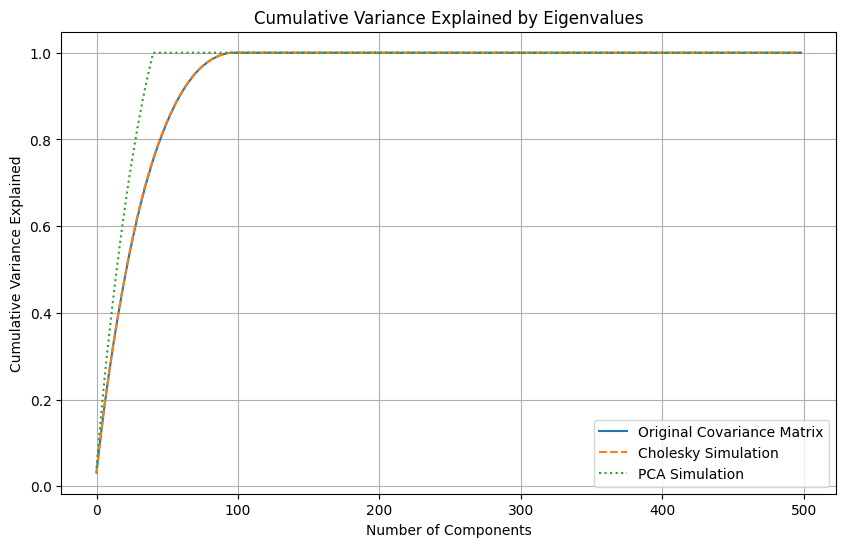

In [257]:
# ---------------- Plot Cumulative Variance Explained ----------------
plt.figure(figsize=(10, 6))
plt.plot(cumulative_variance_original, label="Original Covariance Matrix")
plt.plot(cumulative_variance_cholesky, label="Cholesky Simulation", linestyle="--")
plt.plot(cumulative_variance_pca, label="PCA Simulation", linestyle=":")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Variance Explained")
plt.title("Cumulative Variance Explained by Eigenvalues")
plt.legend()
plt.grid()
plt.show()